In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [38]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras import layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import os
import shutil
import warnings
warnings.filterwarnings('ignore')

# Visualise the Images

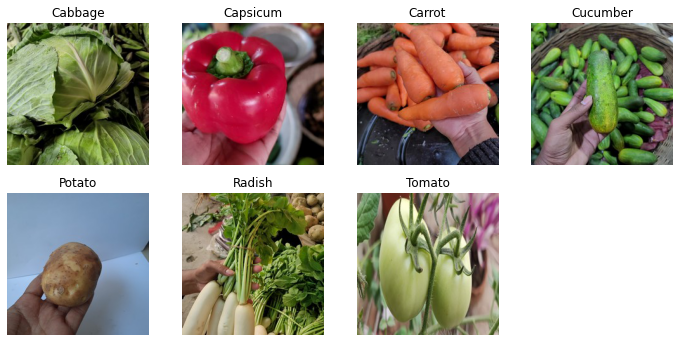

In [3]:
# Let's plot a few images
train_path = "/content/gdrive/MyDrive/Datasets/Vegetable Images/train"
validation_path = "/content/gdrive/MyDrive/Datasets/Vegetable Images/validation"
test_path = "/content/gdrive/MyDrive/Datasets/Vegetable Images/test"

image_categories = os.listdir('/content/gdrive/MyDrive/Datasets/Vegetable Images/train')

def plot_images(image_categories):
    
    # Create a figure
    plt.figure(figsize=(12, 12))
    for i, cat in enumerate(image_categories):
        
        # Load images for the ith category
        image_path = train_path + '/' + cat
        images_in_folder = os.listdir(image_path)
        first_image_of_folder = images_in_folder[0]
        first_image_path = image_path + '/' + first_image_of_folder
        img = image.load_img(first_image_path)
        img_arr = image.img_to_array(img)/255.0
        
        # Create Subplot and plot the images
        plt.subplot(4, 4, i+1)
        plt.imshow(img_arr)
        plt.title(cat)
        plt.axis('off')
        
    plt.show()

# Call the function
plot_images(image_categories)        

# Prepare the Dataset

In [4]:
# Creating Image Data Generator for train, validation and test set

# 1. Train Set
train_gen = ImageDataGenerator(rescale = 1.0/255.0) # Normalise the data
train_image_generator = train_gen.flow_from_directory(
                                            train_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical',
                                            shuffle = True)

# 2. Validation Set
val_gen = ImageDataGenerator(rescale = 1.0/255.0) # Normalise the data
val_image_generator = train_gen.flow_from_directory(
                                            validation_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical',
                                            shuffle = True)

# 3. Test Set
test_gen = ImageDataGenerator(rescale = 1.0/255.0) # Normalise the data
test_image_generator = train_gen.flow_from_directory(
                                            test_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical',
                                            shuffle = True)

Found 6759 images belonging to 7 classes.
Found 1600 images belonging to 7 classes.
Found 950 images belonging to 7 classes.


In [5]:
train = {}
for a in os.listdir(train_path):
  train[a]=len(os.listdir(train_path+"/"+a))
test = {}
for a in os.listdir(test_path):
  test[a]=len(os.listdir(test_path+"/"+a))
validation = {}
for a in os.listdir(validation_path):
  validation[a]=len(os.listdir(validation_path+"/"+a))

In [6]:
print("Train\n",train)
print("Test\n",test)
print("Validation\n",validation)

Train
 {'Cabbage': 996, 'Capsicum': 958, 'Carrot': 965, 'Cucumber': 953, 'Potato': 952, 'Radish': 977, 'Tomato': 958}
Test
 {'Cabbage': 124, 'Capsicum': 127, 'Carrot': 131, 'Cucumber': 146, 'Potato': 148, 'Radish': 126, 'Tomato': 148}
Validation
 {'Cabbage': 222, 'Capsicum': 238, 'Carrot': 239, 'Cucumber': 208, 'Potato': 206, 'Radish': 243, 'Tomato': 244}


Text(0.5, 1.0, 'Training Data')

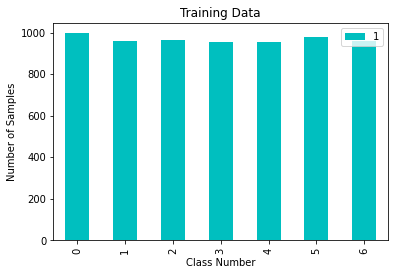

In [7]:
df=pd.DataFrame.from_dict(train.items())
df.plot(kind="bar",color='c')
plt.xlabel("Class Number")
plt.ylabel("Number of Samples")
plt.title("Training Data")

Text(0.5, 1.0, 'Testing Data')

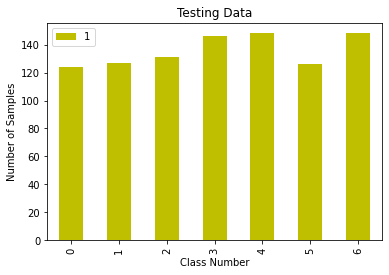

In [8]:
df1=pd.DataFrame.from_dict(test.items())
df1.plot(kind="bar",color='y')
plt.xlabel("Class Number")
plt.ylabel("Number of Samples")
plt.title("Testing Data")

Text(0.5, 1.0, 'Validation Data')

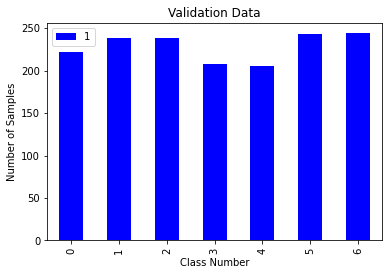

In [9]:
df2=pd.DataFrame.from_dict(validation.items())
df2.plot(kind="bar",color='b')
plt.xlabel("Class Number")
plt.ylabel("Number of Samples")
plt.title("Validation Data")

In [10]:
# Print the class encodings done by the generators
class_map = dict([(v, k) for k, v in train_image_generator.class_indices.items()])
print(class_map)

{0: 'Cabbage', 1: 'Capsicum', 2: 'Carrot', 3: 'Cucumber', 4: 'Potato', 5: 'Radish', 6: 'Tomato'}


# Building a CNN model

In [11]:
# Build a custom sequential CNN model

model = Sequential() # model object

# Add Layers
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=[150, 150, 3]))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(2,2))

# Flatten the feature map
model.add(layers.Flatten())

# Add the fully connected layers
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 128)      0

In [12]:
# Compile and fit the model
early_stopping = keras.callbacks.EarlyStopping(patience=5) # Set up callbacks
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='accuracy')
hist = model.fit(train_image_generator, 
                 epochs=25, 
                 verbose=1, 
                 batch_size=1000,
                 validation_data=val_image_generator, 
                 steps_per_epoch = 7000//1000, 
                 validation_steps = 1400//1000, 
                 callbacks=early_stopping)

Epoch 1/25
7/7 [==============================] - 86s 13s/step - loss: 1.9584 - accuracy: 0.1830 - val_loss: 1.8051 - val_accuracy: 0.2500
Epoch 2/25
7/7 [==============================] - 58s 9s/step - loss: 1.7371 - accuracy: 0.2188 - val_loss: 1.5417 - val_accuracy: 0.4375
Epoch 3/25
7/7 [==============================] - 51s 7s/step - loss: 1.5869 - accuracy: 0.3393 - val_loss: 1.3271 - val_accuracy: 0.4688
Epoch 4/25
7/7 [==============================] - 48s 7s/step - loss: 1.3902 - accuracy: 0.4554 - val_loss: 1.2464 - val_accuracy: 0.6250
Epoch 5/25
7/7 [==============================] - 49s 7s/step - loss: 1.0991 - accuracy: 0.6027 - val_loss: 1.0313 - val_accuracy: 0.6875
Epoch 6/25
7/7 [==============================] - 50s 7s/step - loss: 0.9064 - accuracy: 0.6518 - val_loss: 0.9059 - val_accuracy: 0.5000
Epoch 7/25
7/7 [==============================] - 40s 6s/step - loss: 1.0663 - accuracy: 0.6683 - val_loss: 1.3278 - val_accuracy: 0.6562
Epoch 8/25
7/7 [=================

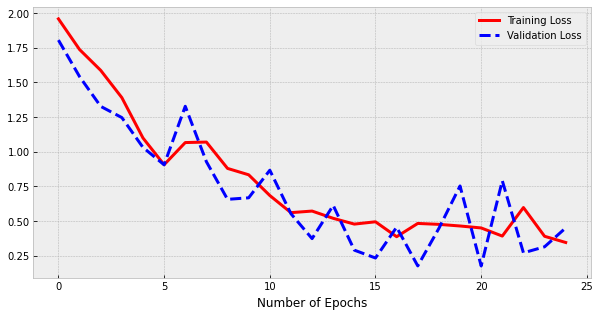

In [13]:
# Plot the error and accuracy
h = hist.history
plt.style.use('bmh')
plt.figure(figsize=(10, 5))
plt.plot(h['loss'], c='red',linewidth=3, label='Training Loss')
plt.plot(h['val_loss'], c='blue',linewidth=3, linestyle='--', label='Validation Loss')
plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

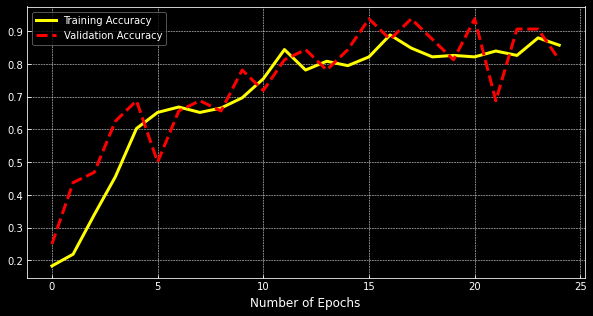

In [14]:
h = hist.history
plt.style.use('dark_background')
plt.figure(figsize=(10, 5))
plt.plot(h['accuracy'], c='yellow',linewidth=3, label='Training Accuracy')
plt.plot(h['val_accuracy'], c='red',linewidth=3, linestyle='--', label='Validation Accuracy')
plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

In [15]:
# Predict the accuracy for the test set
model.evaluate(test_image_generator)

30/30 [==============================] - 238s 8s/step - loss: 0.3655 - accuracy: 0.8716


[0.3655189275741577, 0.8715789318084717]

In [39]:
y_test = test_image_generator.classes
y_pred = model.predict(test_image_generator)
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([1, 3, 1, 6, 1, 6, 2, 0, 6, 2, 5, 3, 2, 1, 0, 1, 3, 0, 1, 0, 6, 0,
       5, 0, 5, 4, 4, 4, 4, 3, 5, 5, 4, 3, 2, 4, 4, 1, 3, 3, 3, 2, 3, 6,
       1, 1, 1, 6, 1, 4, 6, 4, 4, 5, 3, 3, 2, 1, 5, 1, 5, 3, 0, 4, 4, 0,
       6, 0, 2, 0, 4, 0, 5, 3, 5, 5, 5, 5, 1, 6, 3, 3, 3, 5, 4, 4, 3, 5,
       0, 3, 5, 3, 1, 6, 2, 6, 0, 4, 0, 4, 4, 5, 0, 2, 1, 6, 4, 4, 1, 3,
       5, 0, 4, 3, 2, 5, 6, 5, 0, 5, 6, 5, 4, 6, 1, 3, 5, 0, 5, 0, 3, 0,
       1, 3, 5, 6, 5, 3, 6, 4, 0, 3, 1, 0, 0, 4, 1, 5, 3, 2, 2, 2, 1, 2,
       0, 0, 1, 2, 3, 0, 4, 3, 6, 0, 2, 2, 3, 6, 5, 2, 5, 2, 2, 3, 6, 1,
       5, 2, 4, 4, 3, 5, 5, 1, 3, 2, 1, 3, 3, 3, 0, 4, 0, 3, 0, 4, 3, 6,
       3, 4, 2, 0, 3, 2, 2, 3, 1, 5, 5, 3, 1, 5, 2, 1, 0, 1, 2, 5, 3, 1,
       3, 2, 0, 4, 4, 3, 3, 1, 6, 3, 3, 3, 4, 0, 4, 0, 1, 3, 4, 3, 2, 3,
       6, 2, 1, 2, 6, 0, 3, 3, 0, 4, 5, 4, 5, 6, 0, 3, 5, 2, 2, 5, 3, 4,
       1, 3, 0, 3, 0, 5, 4, 1, 3, 2, 4, 4, 0, 4, 2, 6, 4, 2, 4, 4, 2, 3,
       4, 1, 4, 4, 2, 1, 4, 4, 6, 2, 1, 0, 3, 5, 0,

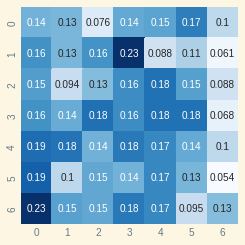

In [40]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = conf_mat / conf_mat.astype(np.float).sum(axis=1)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', cbar=False)

In [41]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.11      0.14      0.12       124
           1       0.14      0.13      0.14       127
           2       0.13      0.13      0.13       131
           3       0.14      0.16      0.15       146
           4       0.15      0.17      0.16       148
           5       0.14      0.13      0.14       126
           6       0.21      0.13      0.16       148

    accuracy                           0.14       950
   macro avg       0.15      0.14      0.14       950
weighted avg       0.15      0.14      0.14       950



In [53]:
h = hist.history
df_1 = pd.DataFrame((h["accuracy"],h["val_accuracy"],h["loss"],h["val_loss"])).T
df_1.columns = ["Acc" , "Val_Acc","Loss","Val_Loss"]
df_1

,Acc,Val_Acc,Loss,Val_Loss
0,0.183036,0.25000,1.958360,1.805141
1,0.218750,0.43750,1.737052,1.541670
2,0.339286,0.46875,1.586851,1.327144
3,0.455357,0.62500,1.390201,1.246382
4,0.602679,0.68750,1.099126,1.031257
5,0.651786,0.50000,0.906389,0.905875
6,0.668342,0.65625,1.066269,1.327845
7,0.651786,0.68750,1.069847,0.928325
8,0.665179,0.65625,0.879827,0.656816
9,0.696429,0.78125,0.833827,0.667872


In [54]:
df_1.to_csv("Model_History.csv")

In [18]:
# Build a custom sequential CNN model

model_2 = Sequential() # model object

# Add Layers
model_2.add(layers.Conv2D(filters=32, kernel_size=(5,5), strides=1, padding='valid', activation='relu', input_shape=[150, 150, 3]))
model_2.add(layers.MaxPooling2D(2,2))
model_2.add(layers.Conv2D(filters=64, kernel_size=(5,5), strides=1, padding='valid', activation='relu'))
model_2.add(layers.MaxPooling2D(2,2))
model_2.add(layers.Conv2D(filters=128, kernel_size=(5,5), strides=1, padding='valid', activation='relu'))
model_2.add(layers.MaxPooling2D(2,2))


# Flatten the feature map
model_2.add(layers.Flatten())

# Add the fully connected layers
model_2.add(layers.Dense(512, activation='relu'))
model_2.add(layers.Dense(7, activation='softmax'))

# print the model summary
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 69, 69, 64)        51264     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 34, 34, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 128)       204928    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 128)     

In [19]:
# Compile and fit the model
early_stopping = keras.callbacks.EarlyStopping(patience=5) # Set up callbacks
model_2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='accuracy')
hist_2 = model_2.fit(train_image_generator, 
                 epochs=25, 
                 verbose=1, 
                 batch_size=1000,
                 validation_data=val_image_generator, 
                 steps_per_epoch = 7000//1000, 
                 validation_steps = 1400//1000, 
                 callbacks=early_stopping)

Epoch 1/25
7/7 [==============================] - 30s 4s/step - loss: 2.5755 - accuracy: 0.1652 - val_loss: 1.9538 - val_accuracy: 0.0938
Epoch 2/25
7/7 [==============================] - 28s 4s/step - loss: 1.8489 - accuracy: 0.1920 - val_loss: 1.8303 - val_accuracy: 0.2188
Epoch 3/25
7/7 [==============================] - 31s 4s/step - loss: 1.4429 - accuracy: 0.4464 - val_loss: 1.2298 - val_accuracy: 0.5625
Epoch 4/25
7/7 [==============================] - 28s 4s/step - loss: 1.1585 - accuracy: 0.5625 - val_loss: 1.2614 - val_accuracy: 0.4062
Epoch 5/25
7/7 [==============================] - 26s 4s/step - loss: 1.1067 - accuracy: 0.5625 - val_loss: 1.3042 - val_accuracy: 0.5625
Epoch 6/25
7/7 [==============================] - 26s 4s/step - loss: 0.9000 - accuracy: 0.6652 - val_loss: 1.0011 - val_accuracy: 0.5625
Epoch 7/25
7/7 [==============================] - 26s 4s/step - loss: 0.7962 - accuracy: 0.6830 - val_loss: 1.1574 - val_accuracy: 0.5312
Epoch 8/25
7/7 [==================

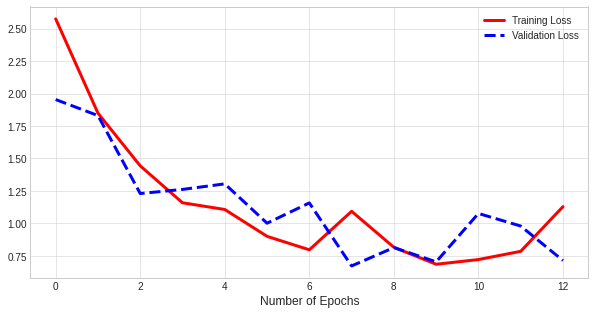

In [20]:
# Plot the error and accuracy
h = hist_2.history
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 5))
plt.plot(h['loss'], c='red',linewidth=3, label='Training Loss')
plt.plot(h['val_loss'], c='blue',linewidth=3, linestyle='--', label='Validation Loss')
plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

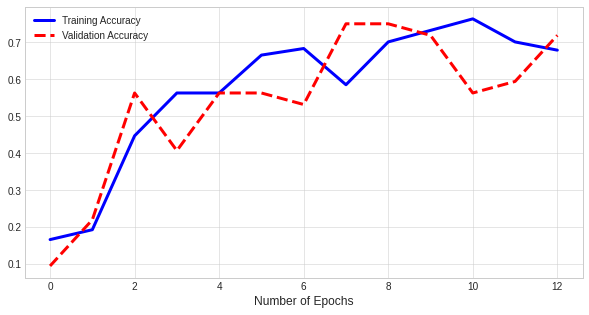

In [21]:
h = hist_2.history
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 5))
plt.plot(h['accuracy'], c='blue',linewidth=3, label='Training Accuracy')
plt.plot(h['val_accuracy'], c='red',linewidth=3, linestyle='--', label='Validation Accuracy')
plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

In [22]:
# Predict the accuracy for the test set
model_2.evaluate(test_image_generator)

30/30 [==============================] - 23s 776ms/step - loss: 1.1502 - accuracy: 0.6011


[1.1501823663711548, 0.6010526418685913]

In [42]:
y_test = test_image_generator.classes
y_pred = model_2.predict(test_image_generator)
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([5, 3, 2, 5, 6, 0, 6, 0, 0, 3, 6, 6, 6, 4, 3, 4, 6, 3, 4, 5, 4, 0,
       0, 5, 2, 6, 2, 6, 3, 6, 4, 4, 4, 3, 5, 0, 5, 2, 4, 6, 4, 5, 5, 2,
       5, 5, 2, 5, 5, 4, 4, 6, 3, 5, 5, 0, 6, 3, 2, 4, 0, 6, 3, 4, 6, 4,
       2, 0, 0, 4, 4, 2, 0, 5, 3, 6, 3, 6, 3, 4, 0, 4, 0, 5, 1, 2, 1, 3,
       0, 6, 5, 0, 5, 5, 2, 5, 5, 2, 2, 4, 4, 3, 3, 6, 6, 0, 0, 0, 6, 6,
       5, 0, 4, 3, 4, 2, 6, 0, 5, 3, 6, 4, 2, 4, 6, 6, 5, 3, 5, 6, 2, 6,
       6, 6, 5, 3, 6, 4, 0, 3, 0, 2, 1, 3, 4, 4, 0, 6, 4, 5, 3, 3, 4, 6,
       4, 4, 4, 5, 0, 4, 2, 4, 4, 0, 4, 6, 0, 5, 0, 6, 5, 4, 5, 3, 2, 6,
       4, 4, 4, 2, 5, 0, 0, 3, 0, 3, 5, 5, 5, 2, 4, 0, 2, 4, 4, 4, 6, 0,
       2, 3, 2, 1, 6, 4, 6, 0, 3, 3, 1, 5, 5, 4, 4, 2, 2, 3, 5, 6, 6, 6,
       6, 3, 0, 4, 3, 3, 4, 6, 6, 4, 5, 6, 4, 3, 4, 5, 1, 6, 0, 1, 6, 5,
       1, 0, 4, 6, 4, 5, 2, 6, 3, 6, 6, 2, 6, 3, 5, 5, 4, 6, 5, 5, 3, 3,
       3, 3, 6, 4, 4, 4, 3, 5, 4, 3, 1, 6, 0, 5, 0, 4, 5, 6, 5, 4, 5, 5,
       2, 4, 5, 3, 3, 4, 4, 3, 6, 4, 2, 6, 4, 0, 5,

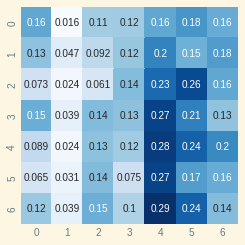

In [43]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = conf_mat / conf_mat.astype(np.float).sum(axis=1)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', cbar=False)

In [46]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.20      0.16      0.18       124
           1       0.21      0.05      0.08       127
           2       0.07      0.06      0.07       131
           3       0.16      0.13      0.14       146
           4       0.16      0.28      0.20       148
           5       0.12      0.17      0.14       126
           6       0.12      0.14      0.13       148

    accuracy                           0.14       950
   macro avg       0.15      0.14      0.13       950
weighted avg       0.15      0.14      0.14       950



In [25]:
# Build a custom sequential CNN model

model_3 = Sequential() # model object

# Add Layers
model_3.add(layers.Conv2D(filters=32, kernel_size=(3,3), strides=2, padding='same', activation='relu', input_shape=[150, 150, 3]))
model_3.add(layers.MaxPooling2D(2,2))
model_3.add(layers.Conv2D(filters=64, kernel_size=(5,5), strides=2, padding='same', activation='relu'))
model_3.add(layers.MaxPooling2D(2,2))
model_3.add(layers.Conv2D(filters=128, kernel_size=(3,3), strides=2, padding='same', activation='relu'))
model_3.add(layers.MaxPooling2D(2,2))


# Flatten the feature map
model_3.add(layers.Flatten())

# Add the fully connected layers
model_3.add(layers.Dense(256, activation='relu'))
model_3.add(layers.Dense(7, activation='softmax'))

# print the model summary
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 75, 75, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 19, 19, 64)        51264     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 2, 2, 128)       

In [26]:
# Compile and fit the model
early_stopping = keras.callbacks.EarlyStopping(patience=5) # Set up callbacks
model_3.compile(optimizer='SGD', loss='categorical_crossentropy', metrics='accuracy')
hist_3 = model_3.fit(train_image_generator, 
                 epochs=25, 
                 verbose=1, 
                 batch_size=1000,
                 validation_data=val_image_generator, 
                 steps_per_epoch = 7000//1000, 
                 validation_steps = 1400//1000, 
                 callbacks=early_stopping)

Epoch 1/25
7/7 [==============================] - 18s 2s/step - loss: 1.9494 - accuracy: 0.1518 - val_loss: 1.9392 - val_accuracy: 0.2500
Epoch 2/25
7/7 [==============================] - 13s 2s/step - loss: 1.9343 - accuracy: 0.2098 - val_loss: 1.9481 - val_accuracy: 0.1562
Epoch 3/25
7/7 [==============================] - 10s 1s/step - loss: 1.9421 - accuracy: 0.1250 - val_loss: 1.9446 - val_accuracy: 0.1562
Epoch 4/25
7/7 [==============================] - 13s 2s/step - loss: 1.9422 - accuracy: 0.1071 - val_loss: 1.9442 - val_accuracy: 0.0625
Epoch 5/25
7/7 [==============================] - 11s 2s/step - loss: 1.9331 - accuracy: 0.2009 - val_loss: 1.9459 - val_accuracy: 0.1562
Epoch 6/25
7/7 [==============================] - 10s 1s/step - loss: 1.9383 - accuracy: 0.1607 - val_loss: 1.9298 - val_accuracy: 0.2500
Epoch 7/25
7/7 [==============================] - 10s 1s/step - loss: 1.9363 - accuracy: 0.1741 - val_loss: 1.9438 - val_accuracy: 0.1562
Epoch 8/25
7/7 [==================

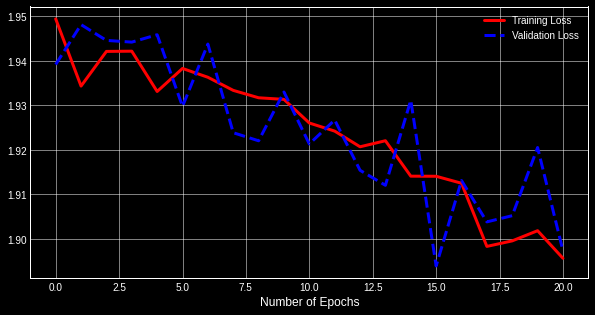

In [28]:
# Plot the error and accuracy
h = hist_3.history
plt.style.use('dark_background')
plt.figure(figsize=(10, 5))
plt.plot(h['loss'], c='red',linewidth=3, label='Training Loss')
plt.plot(h['val_loss'], c='blue',linewidth=3, linestyle='--', label='Validation Loss')
plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

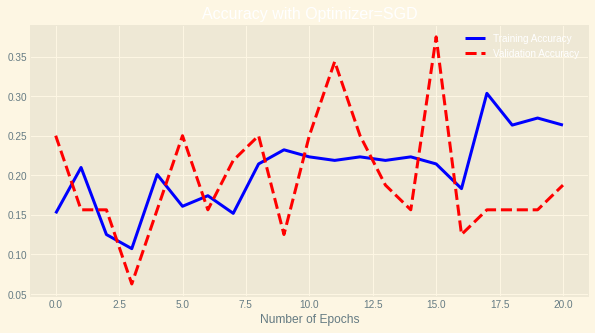

In [29]:
h = hist_3.history
plt.style.use('Solarize_Light2')
plt.figure(figsize=(10, 5))
plt.plot(h['accuracy'], c='blue',linewidth=3, label='Training Accuracy')
plt.plot(h['val_accuracy'], c='red',linewidth=3, linestyle='--', label='Validation Accuracy')
plt.xlabel("Number of Epochs")
plt.title("Accuracy with Optimizer=SGD")
plt.legend(loc='best')
plt.show()

In [30]:
# Predict the accuracy for the test set
model_3.evaluate(test_image_generator)

30/30 [==============================] - 7s 214ms/step - loss: 1.8931 - accuracy: 0.2011


[1.8931124210357666, 0.20105263590812683]

In [47]:
y_test = test_image_generator.classes
y_pred = model_3.predict(test_image_generator)
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0,
       0, 0, 0, 6, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0,
       0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 4, 0, 4, 0, 6, 0, 0, 0, 0, 4, 0,
       0, 0, 4, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0,
       0, 0, 6, 4, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 6, 0, 4, 0, 0, 0,
       0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0,
       0, 0, 0, 0, 4, 1, 0, 0, 0, 4, 0, 0, 0, 0, 1, 0, 0, 4, 0, 4, 0, 4,
       0, 0, 0, 0, 4, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 4,
       0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 4,
       0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 4, 4,
       4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0,
       0, 0, 4, 4, 0, 0, 0, 0, 0, 4, 0, 4, 0, 6, 4, 0, 4, 0, 0, 4, 0, 6,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,

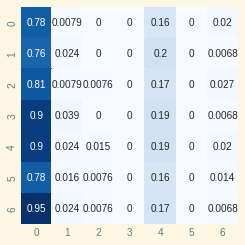

In [48]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = conf_mat / conf_mat.astype(np.float).sum(axis=1)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', cbar=False)

In [50]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.13      0.78      0.23       124
           1       0.17      0.02      0.04       127
           2       0.20      0.01      0.01       131
           3       0.00      0.00      0.00       146
           4       0.15      0.19      0.17       148
           5       0.00      0.00      0.00       126
           6       0.07      0.01      0.01       148

    accuracy                           0.14       950
   macro avg       0.10      0.14      0.07       950
weighted avg       0.10      0.14      0.07       950



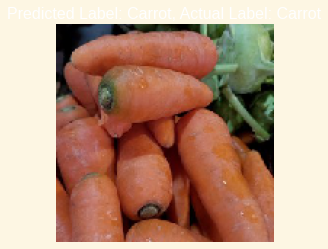

In [35]:
# Testing the Model
test_image_path = '/content/gdrive/MyDrive/Datasets/Vegetable Images/test/Carrot/1070.jpg'

def generate_predictions(test_image_path, actual_label):
    
    # 1. Load and preprocess the image
    test_img = image.load_img(test_image_path, target_size=(150, 150))
    test_img_arr = image.img_to_array(test_img)/255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

    # 2. Make Predictions
    predicted_label = np.argmax(model.predict(test_img_input))
    predicted_vegetable = class_map[predicted_label]
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title("Predicted Label: {}, Actual Label: {}".format(predicted_vegetable, actual_label))
    plt.grid()
    plt.axis('off')
    plt.show()

# call the function
generate_predictions(test_image_path, actual_label='Carrot')

In [36]:
!wget "https://www.dropbox.com/s/lge1plvr4mg5w7y/potato_2.jpg?dl=0"

--2022-03-28 18:46:12--  https://www.dropbox.com/s/lge1plvr4mg5w7y/potato_2.jpg?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/lge1plvr4mg5w7y/potato_2.jpg [following]
--2022-03-28 18:46:12--  https://www.dropbox.com/s/raw/lge1plvr4mg5w7y/potato_2.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb6f66ba4d3676f9f337d423e4a.dl.dropboxusercontent.com/cd/0/inline/BiVCS0Bo7ICebMTH5vD0I4HGjuss8DddJNDksBZhUxLS8YDQItI4utkxuP8VilPcCj8tA5zQJgv_a7-UUvy6ZRX1Wld7B8OtKLKxQ5u8O2e2-7yoLMb1ee9WASSXROi7Ub_Yx5aoE71Pk6XdvaAQoLldge_E26iOnudobwbuHYNk8w/file# [following]
--2022-03-28 18:46:13--  https://ucb6f66ba4d3676f9f337d423e4a.dl.dropboxusercontent.com/cd/0/inline/BiVCS0Bo7ICebMTH5vD0I4HGjuss8DddJNDksBZhUxLS8YDQItI4utkxuP8VilP

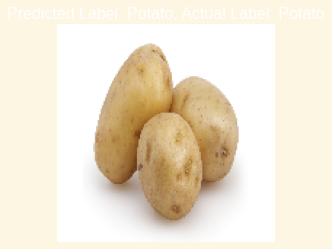

In [37]:
# Generate predictions for external image
external_image_path_2 = "./potato_2.jpg?dl=0"
generate_predictions(external_image_path_2, actual_label='Potato')

In [55]:
model.save("/content/gdrive/MyDrive/model_1.h5")

In [56]:
model_2.save("/content/gdrive/MyDrive/model_2.h5")

In [57]:
model_3.save("/content/gdrive/MyDrive/model_3.h5")